# Business Background

##Data Set Information:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe a term deposit (variable y).


## Why Term Deposits Matter to the Bank  
| Reason | Impact |
|--------|--------|
| **Stable, low-cost funding** | TD balances are “sticky” and cheaper than wholesale funding, improving Net Interest Margin (NIM). |
| **Regulatory liquidity** | TDs count toward the Net Stable Funding Ratio (NSFR), supporting APRA compliance. |
| **Cross-sell & retention** | Customers with a TD show higher product depth and lower churn. |
| **Predictable revenue** | TD interest margins are locked in, smoothing earnings volatility. |

---

# Project Pipeline

1. **Data acquisition**  
   Historical `bank-full.csv` with ~45 k campaign records, plus internal customer tables.  

2. **EDA**  
   - Identify skew (e.g balance).  
   - Spot class imbalance (≈ 11 % TD uptake).  

3. **Pre-processing**  
   - Numeric Feature Selection via T-tests.
   - Standard-scale numeric fields for models.  
   - Train/test split (stratified =y) to address imbalance data.  

4. **Handle imbalance**  
   `class_weight='balanced'` for all models; PR-AUC used as main metric.  

5. **Model stack**  
   - Baseline Logistic Regression  
   - LightGBM (tree-based main model)  
   - Random Forest (benchmark)  
   - Decision Tree
   - KNN
   - SVM (non-linear kernel)  

6. **Evaluation**  
   Compared metrics: Accuracy, Precision, Recall, ROC-AUC, CV_ROC-AUC.

7. **Deployment**  
   - Score current non-TD base.
   - Monitor drift and conversion monthly; retrain quarterly.

---

# Business Question vs. Data Questions

| Layer | Key Questions |
|-------|---------------|
| **Business** | • Who should we advertise TDs to right now?<br>• How many customers can marketing realistically contact?<br>• What lift do we achieve vs. previous “spray & pray” campaigns? |
| **Data** | • Which features most influence TD uptake (age, balance, contact month …)?<br>• How balanced is the positive class?<br>• Are there time-seasonality or channel effects?<br>• Any data quality issues (missing, outliers)? |

---

# Key Data Insights
After evaluating six classification models, Random Forest emerged as the most balanced performer with:

Accuracy: 89.3%

Precision: 62.5%

Recall: 21.0%

ROC-AUC: 0.788

Cross-validated ROC-AUC: 0.783

While models like Logistic Regression and LightGBM offered higher recall, they came at the cost of much lower precision — which could mislead campaign efforts. False Positives (predicting a client will subscribe when they won’t) are particularly risky in marketing, as they may lead to wasted follow-ups or misallocated resources. Therefore, we optimized for a balance of precision and ROC-AUC.

---

# Conclusion

The model tracks actual campaign performance month by month fairly closely.


The five numeric features that showed strong statistical separation between classes are:

- age

- balance

- campaign

- pdays

- previous



#**Data Dictionary**


| **Variable**   | **Definition**                                         | **Key** |
|----------------|--------------------------------------------------------|----------------------------------------------------------|
| **age**        | Age of the client                                       | *Integer* |
| **job**        | Type of job                                             | *admin*, *blue-collar*, *entrepreneur*, *housemaid*, *management*, *retired*, *self-employed*, *services*, *student*, *technician*, *unemployed*, *unknown* |
| **marital**    | Marital status                                          | *divorced*, *married*, *single*, *unknown* |
| **education**  | Level of education                                      | *basic.4y*, *basic.6y*, *basic.9y*, *high.school*, *illiterate*, *professional.course*, *university.degree*, *unknown* |
| **default**    | Has credit in default?                                  | *no*, *yes* |
| **balance**    | Average yearly balance                                  | *Numeric* |
| **housing**    | Has housing loan?                                       | *no*, *yes* |
| **loan**       | Has personal loan?                                      | *no*, *yes* |
| **contact**    | Contact communication type                              | *cellular*, *telephone* |
| **day**        | Last contact day                                        | *1-31* (*Numeric*) |
| **month**      | Last contact month of the year                          | *jan*, *feb*, *mar*, *apr*, *may*, *jun*, *jul*, *aug*, *sep*, *oct*, *nov*, *dec* |
| **duration**   | Last contact duration in seconds                        | *Numeric* (*should be discarded for predictive modeling*) |
| **campaign**   | Number of contacts performed during this campaign       | *Numeric* |
| **pdays**      | Number of days since last contact from previous campaign | *999* means not previously contacted |
| **previous**   | Number of contacts performed before this campaign       | *Numeric* |
| **poutcome**   | Outcome of the previous marketing campaign              | *failure*, *nonexistent*, *success* |
| **y**          | Has the client subscribed to a term deposit?            | *yes*, *no* |

---

# **Importing Libraries**

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scipy
from scipy import stats

# Scikit-learn Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# LightGBM
import lightgbm as lgb  # pip install lightgbm


The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will **subscribe a term deposit (variable y).**
https://archive.ics.uci.edu/dataset/222/bank+marketing

In [ ]:
# Dont run this if use VS code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Downloading data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Data set/bank-full.csv', sep=';', header=0)
#Encoding for easier process
df['y'] = df['y'].map({'yes': 1, 'no': 0}) # 1 is target variable
df.rename(columns={'y': 'term_deposit'}, inplace=True)
df.drop(columns=['duration'], inplace=True) # drop as suggested by the data dictiionary
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,0


#**Data Exploration**


In [ ]:
print(df.shape) #print data shape
df.head(5)  # To show first 5 rows of the data set

(45211, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,0


In [ ]:

df.describe(include= 'all').T #Give statistical information about the data set such as mean ,median ,mode,max value,min value
#checking if pdays got 999 because 999 means not previously contacted so we may need to replace it with -1 to better reflect the logic

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,45211.0,NaN,NaN,NaN,40.93621,10.618762,18.0,33.0,39.0,48.0,95.0
job,45211,12,blue-collar,9732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,45211,3,married,27214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,45211,4,secondary,23202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,45211,2,no,44396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,45211.0,NaN,NaN,NaN,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
housing,45211,2,yes,25130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,45211,2,no,37967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,45211,3,cellular,29285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,45211.0,NaN,NaN,NaN,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0


# **Check Duplicate - No Dup - No Action Needed**

In [ ]:
df.duplicated().sum() #To check duplicate values

np.int64(16)

In [ ]:
# Check if theres imbalance data - only 10% is our target variable
print("Positive rate:", df['term_deposit'].mean().round(3)) #round up to 3 digit


Positive rate: 0.117


#**Outlier - Question to ask SME**

In [ ]:
df[df.balance<0]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,term_deposit
25,44,admin.,married,secondary,no,-372,yes,no,unknown,5,may,1,-1,0,unknown,0
28,46,management,single,secondary,no,-246,yes,no,unknown,5,may,2,-1,0,unknown,0
36,25,blue-collar,married,secondary,no,-7,yes,no,unknown,5,may,1,-1,0,unknown,0
37,53,technician,married,secondary,no,-3,no,no,unknown,5,may,1,-1,0,unknown,0
45,36,admin.,single,primary,no,-171,yes,no,unknown,5,may,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44626,31,services,single,secondary,no,-205,no,no,cellular,1,sep,1,579,1,failure,1
44629,28,blue-collar,single,secondary,no,-46,yes,no,cellular,1,sep,1,92,14,success,1
44836,33,blue-collar,married,primary,no,-195,no,no,unknown,20,sep,1,-1,0,unknown,0
44908,48,management,divorced,tertiary,no,-130,yes,no,cellular,29,sep,2,61,9,failure,0


In [ ]:
#Calculate outlier proportion
round(len(df[df.balance<0])/len(df)*100,2)

8.33

# **8.3% of the accounts has negative balance with Max is -8019. Does this include Credit Products Balance such as home loan, credit card, overdraft? If so, credit products balance should be treated differently.**

> Add blockquote




# **Check Missing Values - No missing values - No Action Needed**

In [ ]:
df.info() # Checking for dataset structure, data types, and missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           45211 non-null  int64 
 1   job           45211 non-null  object
 2   marital       45211 non-null  object
 3   education     45211 non-null  object
 4   default       45211 non-null  object
 5   balance       45211 non-null  int64 
 6   housing       45211 non-null  object
 7   loan          45211 non-null  object
 8   contact       45211 non-null  object
 9   day           45211 non-null  int64 
 10  month         45211 non-null  object
 11  campaign      45211 non-null  int64 
 12  pdays         45211 non-null  int64 
 13  previous      45211 non-null  int64 
 14  poutcome      45211 non-null  object
 15  term_deposit  45211 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [ ]:

# Summarizing the unique values in each column to identify outliers by comparing with data dictionary.
df.nunique()



,0
age,77
job,12
marital,3
education,4
default,2
balance,7168
housing,2
loan,2
contact,3
day,31


In [ ]:
df.poutcome.unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

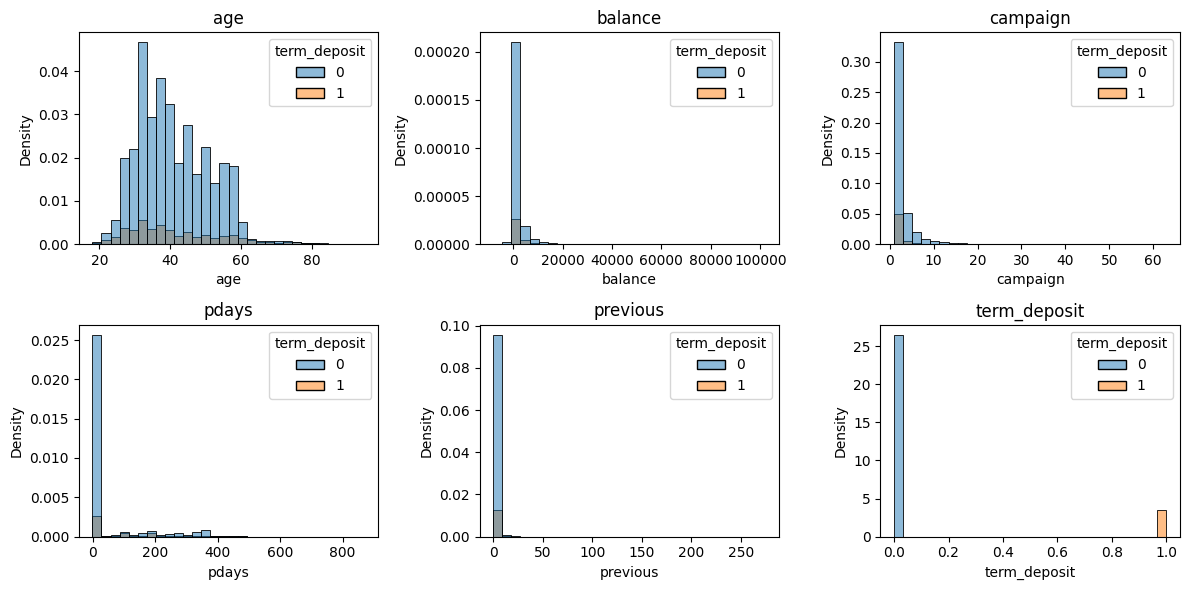

In [ ]:
# 2) Quick numeric EDA
# ----------------------------------
num_cols = ['age', 'balance', 'campaign', 'pdays', 'previous','term_deposit']
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax, col in zip(axs.ravel(), num_cols):
    sns.histplot(df, x=col, hue='term_deposit', bins=30, stat='density', ax=ax)
    ax.set_title(col)
plt.tight_layout(); plt.show()


# **Feature Engineering**

*   Binary age group











In [ ]:
# Binary age group: 'young' if ≤35, else 'older'
df['age_40'] = df['age'].apply(lambda x: 1 if x <= 40 else 0)


In [ ]:
df.corr(numeric_only=True)['term_deposit'].sort_values() #Find correlation between term_deposit and other features.

,term_deposit
campaign,-0.073172
day,-0.028348
age_40,0.009053
age,0.025155
balance,0.052838
previous,0.093236
pdays,0.103621
term_deposit,1.000000


* Correlation is not causation so its best to perform t-test and chi-square test as we have both numerical and categorical features/variables in this data set.
* These tests help understand feature importance based on significance.





# **Feature Selection**






In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose      import ColumnTransformer
from sklearn.pipeline     import Pipeline
from scipy import stats
from sklearn.feature_selection import chi2
import numpy as np
import pandas as pd


In [ ]:
# 1.  Basic split (stratified)

num_cols = ['age', 'balance', 'campaign', 'pdays', 'previous']   # duration already dropped
cat_cols = [c for c in df.columns if c not in num_cols + ['term_deposit']]

X = df.drop('term_deposit', axis=1)
y = df['term_deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# 2.  Fit scaler on TRAIN numerics only

scaler = StandardScaler().fit(X_train[num_cols])

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols] = scaler.transform(X_train[num_cols])
X_test_scaled [num_cols] = scaler.transform(X_test [num_cols])

# sanity-check class balance
print("Positive-rate train:", y_train.mean().round(3),
      "| test:", y_test.mean().round(3))

Positive-rate train: 0.117 | test: 0.117


In [ ]:
# 3.  Welch t-tests on scaled numerics
alpha = 0.05
t_keep = []

for col in num_cols:
    g1 = X_train_scaled.loc[y_train == 1, col]
    g0 = X_train_scaled.loc[y_train == 0, col]
    t, p = stats.ttest_ind(g1, g0, equal_var=False)
    if p < alpha:
        t_keep.append(col)
        print(f"[t-test] {col:<10} p={p:.4g}")

print("\nNumeric features kept:", t_keep)

[t-test] age        p=0.0001552
[t-test] balance    p=4.42e-19
[t-test] campaign   p=3.659e-85
[t-test] pdays      p=2.032e-59
[t-test] previous   p=7.42e-55

Numeric features kept: ['age', 'balance', 'campaign', 'pdays', 'previous']


**How to read a p-value**

A p-value below 0.05 means the difference we observe is very unlikely to be due to random chance.

Lower p-value → stronger evidence that the feature really separates term-deposit takers from non-takers.

**What we’re doing with this information**

We keep the five numeric features above and drop the rest of the numeric columns, reducing noise and speeding up model training. These retained variables will now flow into the next stage: categorical tests, model-based feature selection, and final predictive modeling.

##Preprocessor

In [ ]:
# 0.  Preprocessor: scale numerics, one-hot *all* categoricals

pre = ColumnTransformer([
        ('num', StandardScaler(), t_keep),         # five numeric columns
        ('cat', OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False), cat_cols)   # keep ALL cats
])

# 1.  Helper to evaluate & return metrics
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, roc_auc_score,
                             confusion_matrix)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import pandas as pd, numpy as np, matplotlib.pyplot as plt

def evaluate(model_name, estimator):
    """Fit pipeline, compute metrics, return dict."""
    estimator.fit(X_train, y_train)
    proba = estimator.predict_proba(X_test)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    acc  = accuracy_score (y_test, pred)
    prec = precision_score(y_test, pred)
    rec  = recall_score   (y_test, pred)
    roc  = roc_auc_score  (y_test, proba)

    cv_auc = cross_val_score(
                estimator, X_train, y_train,
                cv=StratifiedKFold(5, shuffle=True, random_state=42),
                scoring='roc_auc'
             ).mean()

    print(f"{model_name:12s}  Acc={acc:.3f}  Prec={prec:.3f}  "
          f"Rec={rec:.3f}  ROC={roc:.3f}  CV_ROC={cv_auc:.3f}")

    return dict(Model=model_name, Accuracy=acc,
                Precision=prec, Recall=rec,
                ROC_AUC=roc, CV_ROC_AUC=cv_auc)

# 2.  Model dict (same as before)
models = {
    'Logistic'      : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'DecisionTree'  : DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42),
    'KNN'           : KNeighborsClassifier(n_neighbors=15),
    'SVM'           : SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    'RandomForest'  : RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=42),
    'LightGBM'      : lgb.LGBMClassifier(objective='binary', n_estimators=600,
                                         learning_rate=0.05, class_weight='balanced',
                                         random_state=42)
}

# 3.  Iterate, evaluate, collect metrics
all_metrics = []

for name, clf in models.items():
    needs_smote = isinstance(clf, KNeighborsClassifier)
    steps = [('prep', pre)]
    if needs_smote:
        steps.append(('sm', SMOTE(random_state=42)))
    steps.append(('clf', clf))
    pipe = ImbPipeline(steps) if needs_smote else Pipeline(steps)

    m = evaluate(name, pipe)
    all_metrics.append(m)




Logistic      Acc=0.763  Prec=0.276  Rec=0.632  ROC=0.774  CV_ROC=0.770
DecisionTree  Acc=0.831  Prec=0.290  Rec=0.305  ROC=0.603  CV_ROC=0.611
KNN           Acc=0.627  Prec=0.198  Rec=0.716  ROC=0.732  CV_ROC=0.729
SVM           Acc=0.889  Prec=0.585  Rec=0.180  ROC=0.797  CV_ROC=0.786
RandomForest  Acc=0.893  Prec=0.625  Rec=0.210  ROC=0.788  CV_ROC=0.783


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3385, number of negative: 25549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 28934, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3385, number of negative: 25549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 28934, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3384, number of negative: 25550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 28934, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3385, number of negative: 25550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 28935, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3385, number of negative: 25550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 28935, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM      Acc=0.831  Prec=0.365  Rec=0.601  ROC=0.783  CV_ROC=0.784


In [ ]:
# 4.  Summary table

summary = (pd.DataFrame(all_metrics)
             .set_index('Model')
             .round(3)
             .sort_values('ROC_AUC', ascending=False))

print("\n=== Model comparison ===")
display(summary)


=== Model comparison ===


,Accuracy,Precision,Recall,ROC_AUC,CV_ROC_AUC
Model,,,,,
SVM,0.889,0.585,0.180,0.797,0.786
RandomForest,0.893,0.625,0.210,0.788,0.783
LightGBM,0.831,0.365,0.601,0.783,0.784
Logistic,0.763,0.276,0.632,0.774,0.770
KNN,0.627,0.198,0.716,0.732,0.729
DecisionTree,0.831,0.290,0.305,0.603,0.611


#How to read this:
**Accuracy**: % of total correct predictions

Ex: Model got 76 out of 100 predictions right.

**Precision**: % of predicted positives that were actually positive

Ex: Of 100 customers flagged to churn, only 27 actually did.

**Recall**: % of actual positives that were correctly predicted

Ex: Of 100 customers who churned, model caught 63.

**ROC AUC**: Measures how well the model separates classes (1 = perfect, 0.5 = random)

Higher is better — Logistic Regression separates classes better than Decision Tree.

**CV ROC AUC**: Cross-validated ROC AUC — more reliable estimate of model performance on unseen data.

# Plot Actual vs Predicted

In [ ]:

# 0.  Build & fit the Random-Forest pipeline
from sklearn.pipeline   import Pipeline
from sklearn.ensemble   import RandomForestClassifier
from sklearn.metrics    import (accuracy_score, precision_score,
                                recall_score, roc_auc_score)
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.compose          import ColumnTransformer
from sklearn.preprocessing    import StandardScaler, OneHotEncoder

pre = ColumnTransformer([
        ('num', StandardScaler(), t_keep),
        ('cat', OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False), cat_cols)
      ])            # --> numpy matrix: 5 scaled numerics + all dummies

rf_pipe = Pipeline([
        ('prep', pre),                                   # scaler + full OHE
        ('clf',  RandomForestClassifier(
                    n_estimators=400,
                    class_weight='balanced',
                    random_state=42))
])

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'day', 'month', 'poutcome',
                                                   'age_40'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=400, random_state=42))])

In [ ]:
# ---- hold-out metrics ----
proba = rf_pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print(f"Accuracy : {round(accuracy_score(y_test, pred), 3)}")
print(f"Precision: {round(precision_score(y_test, pred), 3)}")
print(f"Recall   : {round(recall_score(y_test, pred), 3)}")
print(f"ROC-AUC  : {round(roc_auc_score(y_test, proba), 3)}")


Accuracy : 0.893
Precision: 0.625
Recall   : 0.21
ROC-AUC  : 0.788


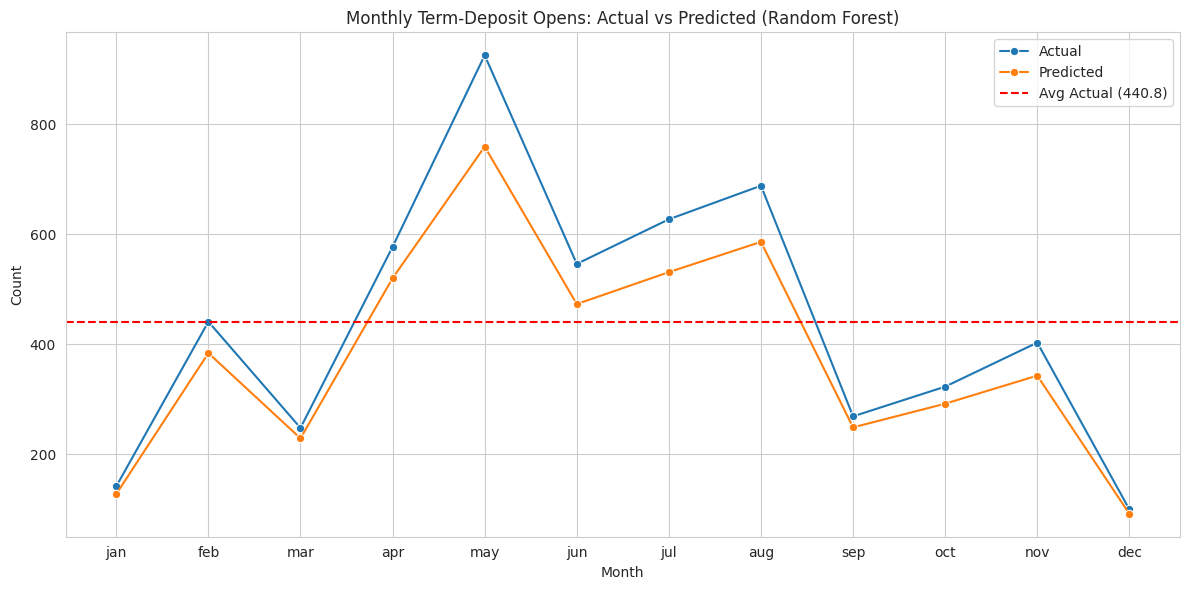

In [ ]:

# 1.  Score the entire dataframe
pred_prob = rf_pipe.predict_proba(df.drop('term_deposit', axis=1))[:, 1]
df['prediction'] = (pred_prob >= 0.50).astype(int)      # 0.50 threshold – adjust if needed


# 2.  Aggregate by the existing 'month' column
#     (strings like "jan","feb" etc.)
# optional: order months correctly
month_order = ['jan','feb','mar','apr','may','jun',
               'jul','aug','sep','oct','nov','dec']

agg = (df
       .groupby('month', observed=True)        # one row per month
       .agg(actual_open   = ('term_deposit', 'sum'),
            predicted_open= ('prediction',   'sum'))
       .reindex(month_order)                   # keep calendar order
       .dropna(how='all')                      # drop months not present
       .reset_index())

mean_open = agg.actual_open.mean()

# --------------------------------------------------
# 3.  Plot Actual vs Predicted
# --------------------------------------------------
import seaborn as sns, matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=agg, x='month', y='actual_open',
             marker='o', label='Actual')
sns.lineplot(data=agg, x='month', y='predicted_open',
             marker='o', label='Predicted')
plt.axhline(mean_open, ls='--', color='red',
            label=f'Avg Actual ({mean_open:.1f})')

plt.title("Monthly Term-Deposit Opens: Actual vs Predicted (Random Forest)")
plt.xlabel("Month"); plt.ylabel("Count"); plt.legend(); plt.tight_layout()
plt.show()
